In [2]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [3]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

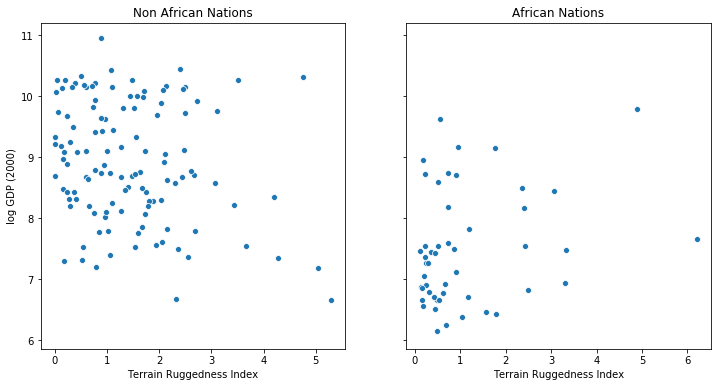

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = data[data["cont_africa"] == 1]
non_african_nations = data[data["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            np.log(non_african_nations["rgdppc_2000"]),
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
            np.log(african_nations["rgdppc_2000"]),
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [5]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.linear(x) + (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)

p = 2  # number of features
regression_model = RegressionModel(p)

In [6]:
def model(x_data, y_data):
    # weight and bias priors
    w_prior = Normal(torch.zeros(1, 2), torch.ones(1, 2)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    f_prior = Normal(0., 1.)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
    scale = pyro.sample("sigma", Uniform(0., 10.))
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean


In [7]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [8]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [11]:
num_iterations = 1000
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train()

[iteration 0001] loss: 18.3907
[iteration 0101] loss: 3.1146
[iteration 0201] loss: 3.1067
[iteration 0301] loss: 2.8602
[iteration 0401] loss: 2.7770
[iteration 0501] loss: 2.6181
[iteration 0601] loss: 2.4298
[iteration 0701] loss: 2.0160
[iteration 0801] loss: 1.7814
[iteration 0901] loss: 1.5811


In [12]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)


In [28]:
eesh = EmpiricalMarginal(trace_pred, ['obs'])._get_samples_and_weights()[0].data.numpy()

In [29]:
eesh.shape

(1000, 1, 170)

In [13]:
# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

In [42]:
mu["5%"], mu["95%"]

(0      7.044759
 1      8.283705
 2      8.873914
 3      8.872734
 4      8.464744
 5      9.008384
 6      8.989214
 7      8.260653
 8      8.693095
 9      7.091609
 10     8.945599
 11     7.007421
 12     7.010370
 13     8.981010
 14     8.731427
 15     8.974326
 16     9.002537
 17     8.547948
 18     8.984230
 19     8.905856
 20     8.857015
 21     8.972651
 22     8.833152
 23     7.008157
 24     7.008443
 25     8.872734
 26     7.952500
 27     8.510318
 28     8.645457
 29     7.009037
          ...   
 140    8.712105
 141    8.506815
 142    8.882976
 143    7.059386
 144    7.029370
 145    8.876467
 146    7.025691
 147    7.014638
 148    8.814428
 149    7.815943
 150    8.964839
 151    8.873127
 152    8.906642
 153    7.033745
 154    8.479100
 155    7.029828
 156    7.048440
 157    8.940595
 158    8.936818
 159    8.809204
 160    8.918689
 161    8.371668
 162    8.900506
 163    8.604439
 164    8.681225
 165    8.691898
 166    8.544930
 167    7.0915

In [15]:
plt.style.use('ggplot')

In [21]:
non_african_nations['mu_perc_5'], non_african_nations['mu_perc_95']

(41     9.008845
 85     9.008384
 5      9.008384
 136    9.006881
 115    9.004335
 16     9.002537
 49     8.992752
 6      8.989214
 95     8.986918
 18     8.984230
 93     8.982196
 13     8.981010
 42     8.980686
 15     8.974326
 21     8.972651
 128    8.971848
 87     8.971848
 65     8.966831
 150    8.964839
 125    8.961878
 51     8.956032
 70     8.952637
 81     8.948458
 10     8.945599
 157    8.940595
 158    8.936818
 73     8.921140
 160    8.918689
 84     8.916048
 55     8.912425
          ...   
 129    8.600534
 63     8.597064
 36     8.591858
 80     8.587520
 90     8.584266
 67     8.583614
 17     8.547948
 166    8.544930
 69     8.535677
 116    8.525875
 74     8.517901
 77     8.515152
 27     8.510318
 141    8.506815
 66     8.505648
 88     8.493507
 154    8.479100
 101    8.469381
 4      8.464744
 37     8.458703
 161    8.371668
 62     8.363690
 1      8.283705
 7      8.260653
 56     8.221389
 89     8.098327
 83     8.075307
 26     7.9525

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

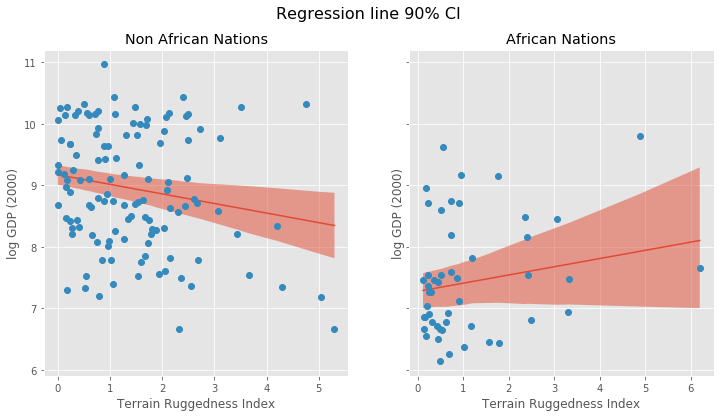

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [34]:
a = np.array([[10, 7, 4], [3, 2, 1]])

In [40]:
np.percentile(a, 50)

3.5

In [46]:
np.array

<function numpy.core.multiarray.array>